<a href="https://colab.research.google.com/github/Lee-Gunju/Lee-Gunju/blob/master/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install rdkit-pypi
!pip install -q git+https://github.com/tensorflow/docs
!pip install -U tensorflow-addons


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from tqdm import tqdm

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader

import gdown
import re
import zipfile

from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa



In [20]:
url = "https://drive.google.com/u/0/uc?export=download&confirm=ynH9&id=1WcW8SbDvkEwtoMR1pOrYeWNa62uYEm9z"

## data download 받고(gdown.download 사용) 압축 풀기
gdown.download(url, 'data.zip', quiet=False)

with zipfile.ZipFile('data.zip', 'r') as z_fp:
  z_fp.extractall('./data')

Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=ynH9&id=1WcW8SbDvkEwtoMR1pOrYeWNa62uYEm9z
To: /content/data.zip
32.0MB [00:00, 140MB/s]


In [21]:
train = pd.read_csv('./data/train.csv')
dev = pd.read_csv('./data/dev.csv')

In [22]:
train = pd.concat([train, dev])

In [23]:
! dir
#path = "data/train_imgs"
!mkdir "data/train_imgs"

for idx, row in tqdm(train.iterrows()):
    file = row['uid']
    smiles = row['SMILES']
    m = Chem.MolFromSmiles(smiles)
    if m != None:
        img = Draw.MolToImage(m, size=(300,300))
        img.save(f'data/train_imgs/{file}.png')

data  data.zip	sample_data
mkdir: cannot create directory ‘data/train_imgs’: File exists


30345it [07:43, 65.45it/s]


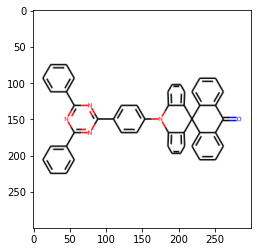

In [24]:
sample_img = cv2.imread('./data/train_imgs/dev_0.png')
plt.imshow(sample_img)
plt.show()

In [71]:
#device = torch.device("cuda:0")
BATCH_SIZE = 64
EPOCHS = 25
num_layers = 1
dropout_rate = 0.1
embedding_dim = 128
#learning_rate = 1e-4
#vision_pretrain = True
save_path = f'./models/best_model.pt'


learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100
image_size = 300  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

input_shape = (300, 300, 3)


In [26]:
#seqs = tokenizer.txt2seq(train.SMILES)
labels = train[['S1_energy(eV)', 'T1_energy(eV)']].to_numpy()
imgs = ('./data/train_imgs/'+train.uid+'.png').to_numpy()

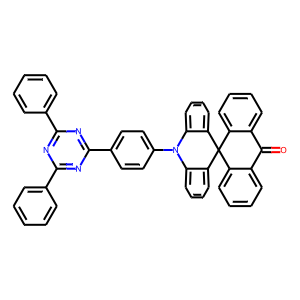

In [26]:
# from keras.preprocessing.image import load_img
# img = load_img('./data/train_imgs/dev_0.png')
# img


In [38]:
#img_path = 'data/'

In [39]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale=1./255)
# target_size = (300, 300)

# train_generator = train_datagen.flow_from_directory(
#     img_path,
#     target_size=target_size,
#     batch_size=BATCH_SIZE,
#     class_mode = None)



Found 30345 images belonging to 4 classes.


In [46]:
img_to = cv2.imread(imgs[0]).astype(np.float32)/255

In [50]:
np.shape(img_to.reshape((1,)+img_to.shape))

(1, 300, 300, 3)

In [51]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

for i, img in tqdm(enumerate(imgs)):
  # 이미지 불러오기
  img_to = cv2.imread(img).astype(np.float32)/255
  img_to = img_to.reshape((1,)+img_to.shape)

  if i == 0:
    img_list = img_to

  else:
    img_list = np.vstack([img_list, img_to])



859it [02:00,  7.10it/s]


KeyboardInterrupt: ignored

In [52]:
len(imgs)

30345

In [53]:
len(img_list)

859

In [54]:
np.shape(img_list)

(859, 300, 300, 3)

In [55]:
train_imgs = img_list[:700]
train_labels = labels[:700]

val_imgs = img_list[700:]
val_labels = labels[700:859]

In [56]:
print(f"x_train shape: {train_imgs.shape} - y_train shape: {train_labels.shape}")
print(f"x_test shape: {val_imgs.shape} - y_test shape: {val_labels.shape}")

x_train shape: (700, 300, 300, 3) - y_train shape: (700, 2)
x_test shape: (159, 300, 300, 3) - y_test shape: (159, 2)


In [58]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train_imgs)

In [59]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [60]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [65]:
np.shape(train_imgs)

(700, 300, 300, 3)

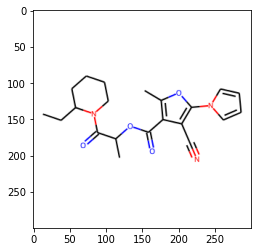

In [66]:
plt.imshow(train_imgs[0])

Image size: 300 X 300
Patch size: 6 X 6
Patches per image: 2500
Elements per patch: 108


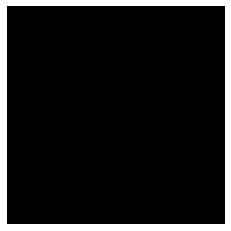

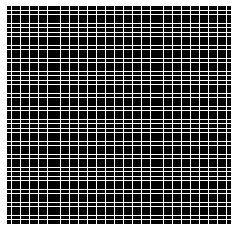

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = train_imgs[np.random.choice(range(train_imgs.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [73]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [74]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(2)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.MeanAbsoluteError()
        #metrics=[
        #    keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        #    keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        #],
    )

    # checkpoint_filepath = "/tmp/checkpoint"
    # checkpoint_callback = keras.callbacks.ModelCheckpoint(
    #     checkpoint_filepath,
    #     monitor="val_accuracy",
    #     save_best_only=True,
    #     save_weights_only=True,
    # )

    history = model.fit(
        x=train_imgs,
        y=train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
        #callbacks=[checkpoint_callback],
    )

    # model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/25
